In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.io
from collections import Counter
from sklearn.svm import SVC
import scipy
from scipy.stats import multivariate_normal

import os
import cv2
import operator

In [6]:
def get_LL(x):
    return np.sum(np.log(np.sum(x, axis=0)))

In [112]:
def kMean(img, K, max_iter):
    # KMEAN PART
    mu = img[np.random.randint(len(img), size = K)]
    gamma = np.ones([len(img), K])
    
    for i in range(max_iter):
        dist = np.sum((img[:, None] - mu)**2, axis=2) 
        gamma_new = np.argmin(dist, axis=1)
        
        if np.array_equiv(gamma, gamma_new) == True:
            break
        else:
            gamma = gamma_new
        #mu = np.sum(gamma[:, :, None] * img[:, None], axis=0) / np.sum(gamma, axis=0)[:, None]
        for j in range(K):
            data_k = img[np.where(gamma == j)]
            if len(data_k) == 0:
                mu[j] = np.random.rand(3)
            else:
                mu[j] = np.mean(data_k, axis=0)
    kmean_table = pd.DataFrame({
        "K-Means": range(K),
        "b": np.round(mu[:, 0] * 255).astype('int'),
        "g": np.round(mu[:, 1] * 255).astype('int'),
        "r": np.round(mu[:, 2] * 255).astype('int'),
    })
    print(tabulate(kmean_table, headers="keys", tablefmt = "fancy_grid"))
    km_img = np.round(mu[gamma.astype('int')] * 255)
    
    # GMM PART
    pi = np.unique(gamma, return_counts = True)[1] / len(gamma)
    sigmak = np.array([np.cov(img[np.where(gamma == i)].T) for i in range(K)])
    p_x = np.array([multivariate_normal.pdf(img, mean=mu[i], cov=sigmak[i]) * pi[i] for i in range(K)])
    
    LL = []
    LL.append(get_LL(p_x))
    
    for j in range(max_iter):
        # add by column
        gamma = (p_x / np.sum(p_x, axis=0)).T
        
        Nk = np.sum(gamma, axis = 0)
        muk_new = np.sum(img[:, np.newaxis] * gamma[:, :, np.newaxis], axis = 0) / Nk[:, np.newaxis]
        for k in range(K):
            sigmak[k] = ((img - muk_new[k]) * gamma[:, k, None]).T.dot(img - muk_new[k]) / Nk[k]
        pi = Nk / len(img)
        
        for l in range(K):
            try:
                p_x[l, :] = multivariate_normal.pdf(img, mean = muk_new[l], cov = sigmak[l]) * pi[l]
            except np.linalg.linalg.LinAlgError:
                muk_new[l] = np.random.rand(3)
                temp = np.random.rand(3, 3)
                sigmak[l] = temp.T.dot(temp)
                p_x[l, :] = multivariate_normal.pdf(img, mean = muk_new[l], cov = sigmak[l]) * pi[l]
                
        LL.append(get_LL(p_x))
    
    gamma = np.argmax(p_x, axis=0)

    GMM_table = pd.DataFrame({
        "GMM": range(K),
        "b": np.round(muk_new[:, 0] * 255).astype('int'),
        "g": np.round(muk_new[:, 1] * 255).astype('int'),
        "r": np.round(muk_new[:, 2] * 255).astype('int'),
    })
    print(tabulate(GMM_table, headers="keys", tablefmt = "fancy_grid"))
    GMM_img = np.round(muk_new[gamma]*255)
    return km_img, GMM_img, LL

In [ ]:
kMean(img, 3, 100)

In [110]:
img = cv2.imread('hw3_3.jpeg')
img = img/255.
img = img.reshape(-1, 3)

╒════╤═══════════╤═════╤═════╤═════╕
│    │   K-Means │   b │   g │   r │
╞════╪═══════════╪═════╪═════╪═════╡
│  0 │         0 │ 214 │ 162 │ 106 │
├────┼───────────┼─────┼─────┼─────┤
│  1 │         1 │  34 │  64 │  65 │
├────┼───────────┼─────┼─────┼─────┤
│  2 │         2 │  27 │ 144 │ 181 │
╘════╧═══════════╧═════╧═════╧═════╛
╒════╤═══════╤═════╤═════╤═════╕
│    │   GMM │   b │   g │   r │
╞════╪═══════╪═════╪═════╪═════╡
│  0 │     0 │ 196 │ 153 │ 105 │
├────┼───────┼─────┼─────┼─────┤
│  1 │     1 │  21 │  81 │  90 │
├────┼───────┼─────┼─────┼─────┤
│  2 │     2 │  11 │ 138 │ 180 │
╘════╧═══════╧═════╧═════╧═════╛


<Figure size 1296x2592 with 0 Axes>

(-0.5, 999.5, 343.5, -0.5)

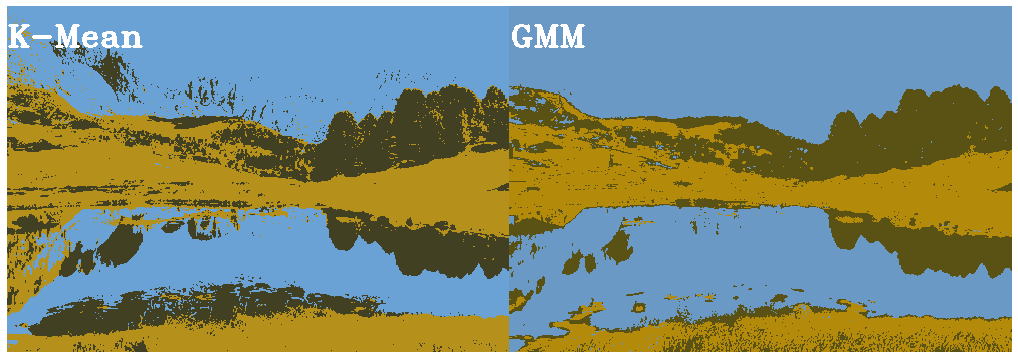

╒════╤═══════════╤═════╤═════╤═════╕
│    │   K-Means │   b │   g │   r │
╞════╪═══════════╪═════╪═════╪═════╡
│  0 │         0 │ 125 │ 108 │  92 │
├────┼───────────┼─────┼─────┼─────┤
│  1 │         1 │ 239 │ 155 │  60 │
├────┼───────────┼─────┼─────┼─────┤
│  2 │         2 │  19 │ 144 │ 183 │
├────┼───────────┼─────┼─────┼─────┤
│  3 │         3 │ 190 │ 194 │ 199 │
├────┼───────────┼─────┼─────┼─────┤
│  4 │         4 │  13 │  57 │  63 │
╘════╧═══════════╧═════╧═════╧═════╛
╒════╤═══════╤═════╤═════╤═════╕
│    │   GMM │   b │   g │   r │
╞════╪═══════╪═════╪═════╪═════╡
│  0 │     0 │ 141 │ 115 │  80 │
├────┼───────┼─────┼─────┼─────┤
│  1 │     1 │ 249 │ 167 │  73 │
├────┼───────┼─────┼─────┼─────┤
│  2 │     2 │  14 │ 137 │ 177 │
├────┼───────┼─────┼─────┼─────┤
│  3 │     3 │ 180 │ 185 │ 195 │
├────┼───────┼─────┼─────┼─────┤
│  4 │     4 │  11 │  56 │  56 │
╘════╧═══════╧═════╧═════╧═════╛


<Figure size 1296x2592 with 0 Axes>

(-0.5, 999.5, 343.5, -0.5)

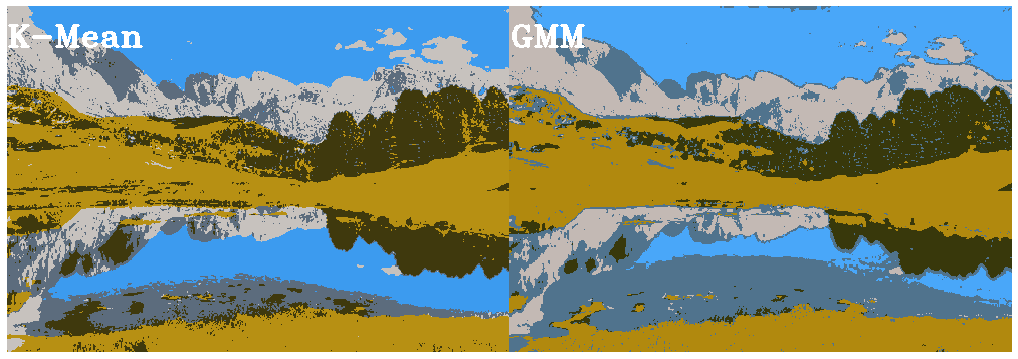

╒════╤═══════════╤═════╤═════╤═════╕
│    │   K-Means │   b │   g │   r │
╞════╪═══════════╪═════╪═════╪═════╡
│  0 │         0 │ 207 │ 209 │ 213 │
├────┼───────────┼─────┼─────┼─────┤
│  1 │         1 │ 246 │ 163 │  69 │
├────┼───────────┼─────┼─────┼─────┤
│  2 │         2 │  13 │  45 │  46 │
├────┼───────────┼─────┼─────┼─────┤
│  3 │         3 │ 161 │ 101 │  41 │
├────┼───────────┼─────┼─────┼─────┤
│  4 │         4 │ 137 │ 145 │ 154 │
├────┼───────────┼─────┼─────┼─────┤
│  5 │         5 │  19 │ 165 │ 206 │
├────┼───────────┼─────┼─────┼─────┤
│  6 │         6 │  20 │ 105 │ 136 │
╘════╧═══════════╧═════╧═════╧═════╛
╒════╤═══════╤═════╤═════╤═════╕
│    │   GMM │   b │   g │   r │
╞════╪═══════╪═════╪═════╪═════╡
│  0 │     0 │ 182 │ 188 │ 199 │
├────┼───────┼─────┼─────┼─────┤
│  1 │     1 │ 249 │ 166 │  76 │
├────┼───────┼─────┼─────┼─────┤
│  2 │     2 │ 205 │ 147 │  79 │
├────┼───────┼─────┼─────┼─────┤
│  3 │     3 │ 229 │ 133 │  21 │
├────┼───────┼─────┼─────┼─────┤
│  4 │  

<Figure size 1296x2592 with 0 Axes>

(-0.5, 999.5, 343.5, -0.5)

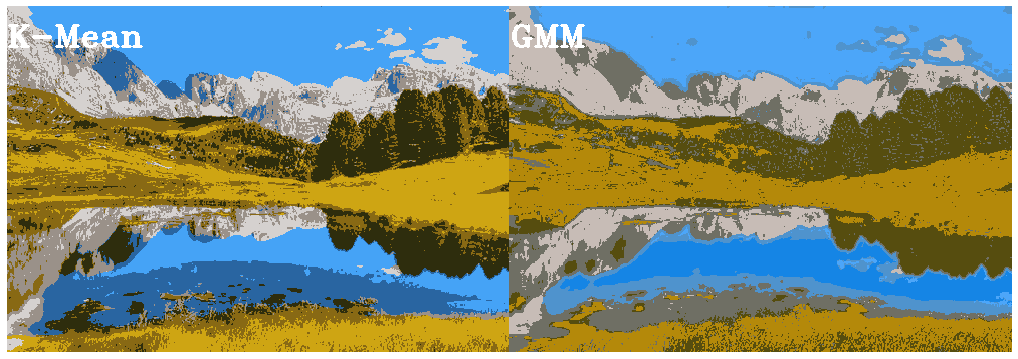

╒════╤═══════════╤═════╤═════╤═════╕
│    │   K-Means │   b │   g │   r │
╞════╪═══════════╪═════╪═════╪═════╡
│  0 │         0 │   6 │  27 │  24 │
├────┼───────────┼─────┼─────┼─────┤
│  1 │         1 │ 121 │  93 │  68 │
├────┼───────────┼─────┼─────┼─────┤
│  2 │         2 │  20 │ 107 │ 139 │
├────┼───────────┼─────┼─────┼─────┤
│  3 │         3 │ 143 │ 152 │ 162 │
├────┼───────────┼─────┼─────┼─────┤
│  4 │         4 │  21 │ 188 │ 225 │
├────┼───────────┼─────┼─────┼─────┤
│  5 │         5 │  16 │  70 │  80 │
├────┼───────────┼─────┼─────┼─────┤
│  6 │         6 │ 209 │ 211 │ 217 │
├────┼───────────┼─────┼─────┼─────┤
│  7 │         7 │ 216 │ 125 │  28 │
├────┼───────────┼─────┼─────┼─────┤
│  8 │         8 │ 249 │ 171 │  80 │
├────┼───────────┼─────┼─────┼─────┤
│  9 │         9 │  17 │ 142 │ 185 │
╘════╧═══════════╧═════╧═════╧═════╛
╒════╤═══════╤═════╤═════╤═════╕
│    │   GMM │   b │   g │   r │
╞════╪═══════╪═════╪═════╪═════╡
│  0 │     0 │ 254 │ 182 │  89 │
├────┼───────┼───

<Figure size 1296x2592 with 0 Axes>

(-0.5, 999.5, 343.5, -0.5)

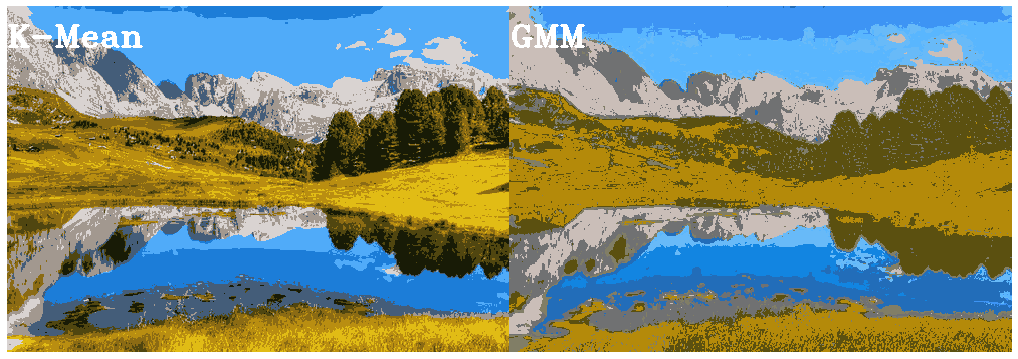

In [142]:
likelihood = []
for i in list([3, 5, 7, 10]):
    km_img, GMM_img, LL = kMean(img, i, 300)
    likelihood.append(LL)
    km_jpg = km_img.reshape(344, 500, -1).astype("int")
    km_jpg = km_jpg[:, :, ::-1]

    GMM_jpg = GMM_img.reshape(344, 500, -1).astype("int")
    GMM_jpg = GMM_jpg[:, :, ::-1]
    
    km_jpg = km_jpg.copy()
    km_jpg = cv2.putText(km_jpg, 'K-Mean', (0, 40), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    GMM_jpg = GMM_jpg.copy()
    GMM_jpg = cv2.putText(GMM_jpg, 'GMM', (0, 40), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    JPG = np.hstack((km_jpg, GMM_jpg))
    
    plt.figure(figsize=(18, 36))
    plt.imshow(JPG)
    plt.axis('off')
    plt.show();

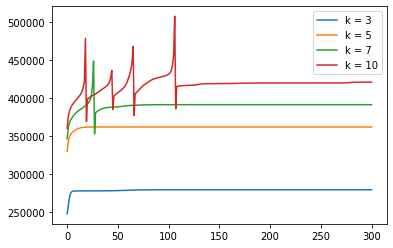

In [143]:
for i in range(4):
    plt.plot(range(301), likelihood[i])
plt.legend(["k = 3", "k = 5", "k = 7", "k = 10"], loc = "best")
plt.show();